# Time Series Preprocessing Pipeline Demo

This notebook demonstrates how to use the preprocessing pipeline for time series data using the Air Passengers dataset from Hugging Face.

The dataset contains monthly air passenger counts from 1949 to 1960. We'll demonstrate:
1. Configuring the preprocessing pipeline
2. Applying batch-level transforms using MeanScaler
3. Visualizing the transformed data


In [32]:
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, IterableDataset
import sys
import os

# Add parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from preprocessing.config import Config, DatasetConfig
from preprocessing.downloader.huggingface import HuggingFaceDownloader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [33]:
# Download and prepare the Air Passengers dataset
config = Config(
    dataset=DatasetConfig(
        name="air-passengers",
        repo_id="duol/airpassengers",
        files=["AP.csv"]  # Pass as a list to avoid string splitting
    ),
)

# Download the dataset
downloader = HuggingFaceDownloader(config.dataset)
data_path = downloader.download()["AP.csv"]  # Get the path from the returned dict

In [34]:
# Read and prepare the CSV data
import pandas as pd
df = pd.read_csv(data_path)
data = df['#Passengers'].values  # Get passenger counts
data = torch.FloatTensor(data).reshape(12, 12, 1)  # (years, months, features)

print("Data shape:", data.shape, "- (years, months, features)")

dataset_raw = TensorDataset(data)
# Create dataset with just the input data (no targets needed)

Data shape: torch.Size([12, 12, 1]) - (years, months, features)


In [35]:
# Preprocess dataset
from preprocessing.transform.transforming_dataset import TransformingDataset
from preprocessing.transform.dataset_builder import Builder

# remove abs mean from each element of the dataset
dataset_iterable = (
    Builder(iter(dataset_raw))
        .map(lambda ts: ts[0] / torch.abs(ts[0]).mean())
        .build()
)

In [36]:
# later we expect a map-like dataset, so, converting it in memory.
# in real world we will use ser/deser

processed_stack = torch.stack(list(dataset_iterable))
print(processed_stack.size())
dataset = TensorDataset(processed_stack)

torch.Size([12, 12, 1])


In [37]:
# Create dataloader
dataloader = DataLoader(
    dataset,  # Use original dataset directly
    batch_size=3,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)


In [38]:
# Get a transformed batch
batch = next(iter(dataloader))
print("Batch type:", type(batch))
print("Batch content:", batch)

# Properly unpack based on the structure
if isinstance(batch, tuple) or isinstance(batch, list):
    transformed_data = batch[0]
else:
    transformed_data = batch

print("\nTransformed batch shape:", transformed_data.shape)

Batch type: <class 'list'>
Batch content: [tensor([[[0.8842],
         [0.9316],
         [1.0421],
         [1.0184],
         [0.9553],
         [1.0658],
         [1.1684],
         [1.1684],
         [1.0737],
         [0.9395],
         [0.8211],
         [0.9316]],

        [[0.8234],
         [0.9021],
         [1.0095],
         [0.9666],
         [0.8950],
         [1.0668],
         [1.2172],
         [1.2172],
         [1.1313],
         [0.9523],
         [0.8162],
         [1.0024]],

        [[0.8521],
         [0.8815],
         [1.0460],
         [0.9579],
         [1.0108],
         [1.0460],
         [1.1694],
         [1.1694],
         [1.0813],
         [0.9520],
         [0.8580],
         [0.9755]]])]

Transformed batch shape: torch.Size([3, 12, 1])


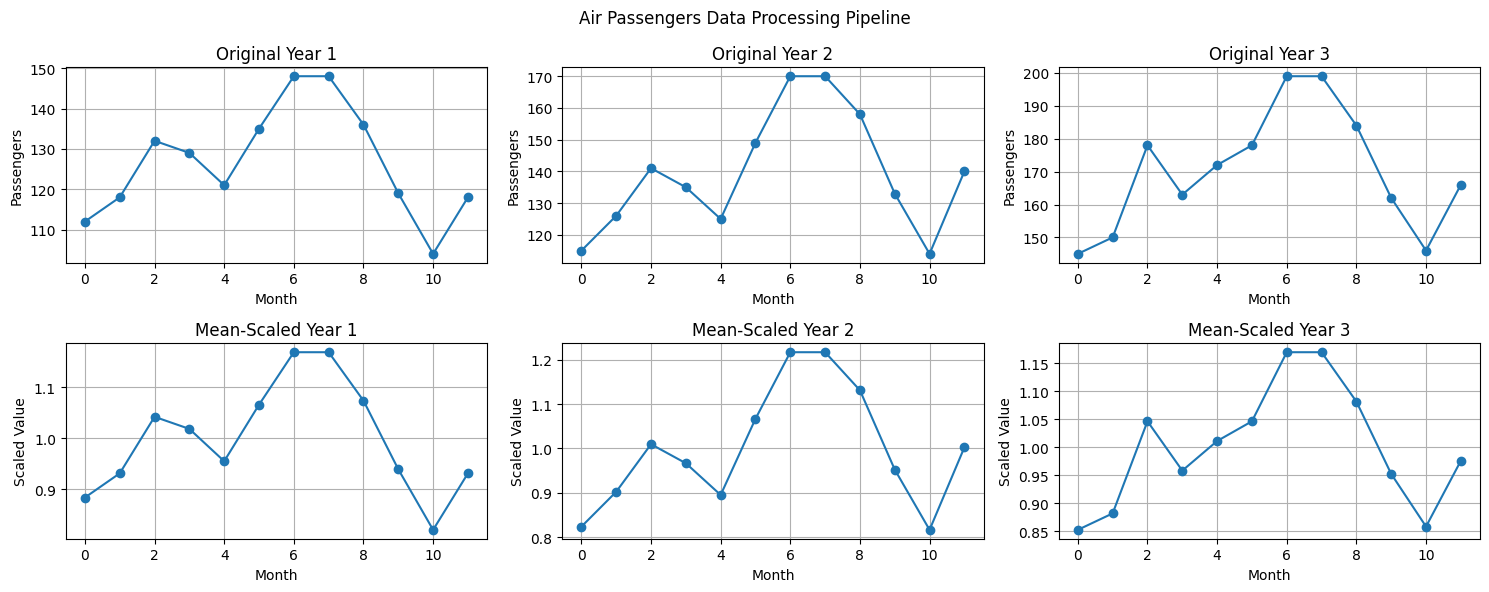

In [39]:
# Visualize original and transformed data
def plot_samples(original, transformed, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Air Passengers Data Processing Pipeline')
    
    for i in range(num_samples):
        # Plot original
        axes[0, i].plot(original[i, :, 0].numpy(), marker='o')
        axes[0, i].set_title(f'Original Year {i+1}')
        axes[0, i].set_xlabel('Month')
        axes[0, i].set_ylabel('Passengers')
        axes[0, i].grid(True)
        
        # Plot transformed
        axes[1, i].plot(transformed[i, :, 0].numpy(), marker='o')
        axes[1, i].set_title(f'Mean-Scaled Year {i+1}')
        axes[1, i].set_xlabel('Month')
        axes[1, i].set_ylabel('Scaled Value')
        axes[1, i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get original data
original_batch = next(iter(DataLoader(dataset_raw, batch_size=3, shuffle=False)))[0]

# Get transformed data
transformed_batch = next(iter(dataloader))
if isinstance(transformed_batch, tuple) or isinstance(batch, list):
    transformed_batch = transformed_batch[0]

# Plot both versions
plot_samples(original_batch, transformed_batch)


In [40]:
# Print some statistics about the transformation
print("Original data statistics:")
print(f"Mean: {original_batch.mean():.4f}")
print(f"Std: {original_batch.std():.4f}")
print(f"Min: {original_batch.min():.4f}")
print(f"Max: {original_batch.max():.4f}")

print("\nTransformed data statistics:")
print(f"Mean: {transformed_batch.mean():.4f}")
print(f"Std: {transformed_batch.std():.4f}")
print(f"Min: {transformed_batch.min():.4f}")
print(f"Max: {transformed_batch.max():.4f}")


Original data statistics:
Mean: 145.5000
Std: 24.9439
Min: 104.0000
Max: 199.0000

Transformed data statistics:
Mean: 1.0000
Std: 0.1151
Min: 0.8162
Max: 1.2172
